#### Objetivo: Implementar un pipeline completo de machine learning para un problema de clasificación utilizando técnicas de preprocesamiento, modelado, y optimización de hiperparámetros. Enfocar especialmente en la limpieza de datos y la optimización utilizando GridSearchCV y RandomizedSearchCV.

DATA:  Medical Cost Personal Dataset    
https://www.kaggle.com/

* 1- Carga y Exploración Inicial de Datos

In [112]:
# Carga de bibliotecas
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
import seaborn as sns

In [113]:
# biblioteca google.
from google.colab import drive
# conecta colab con drive.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
path ="/content/drive/MyDrive/CLASE MACHINE LEARNING/DATA_CORES/insurance.csv"
df = pd.read_csv(path)

In [115]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [117]:
# Se verifica estadistica de las caracteristicas
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.21,14.05,18.00,27.00,39.00,51.00,64.00
bmi,1338.0,30.66,6.10,15.96,26.30,30.40,34.69,53.13
children,1338.0,1.09,1.21,0.00,0.00,1.00,2.00,5.00
charges,1338.0,13270.42,12110.01,1121.87,4740.29,9382.03,16639.91,63770.43


#### Se verifica las columnas numericas, no se observa valores que se alejen de lo normal, por ejemplo los máximos estan levemente sobre el percentil 75 en todas las columnas y la media concuerda con los percentiles.

In [118]:
# Se revisa filas duplicadas
df.duplicated().sum()

np.int64(1)

In [119]:
# Se elimina duplicados
df.drop_duplicates(inplace=True)

In [120]:
# Se revisa posibles valores nulos o falsos nulos
df.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [121]:
# Se revisa columna sex, posibles valores extraños
df["sex"].unique()

array(['female', 'male'], dtype=object)

In [122]:
# Se revisa columna smoker, posibles valores extraños
df["smoker"].unique()

array(['yes', 'no'], dtype=object)

In [123]:
# Se revisa columna region, posibles valores extraños
df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [124]:
# Se revisa columna age, posibles valores extraños
df["age"].value_counts()

,count
age,
18,69
19,67
46,29
52,29
50,29
47,29
48,29
51,29
45,29


In [125]:
# Se revisa columna bmi, posibles valores extraños
df["bmi"].value_counts()

,count
bmi,
32.300,13
28.310,9
30.800,8
31.350,8
30.495,8
...,...
39.425,1
40.480,1
38.900,1


In [126]:
# Se revisa columna bmi, posibles valores extraños
df["bmi"].value_counts()

,count
bmi,
32.300,13
28.310,9
30.800,8
31.350,8
30.495,8
...,...
39.425,1
40.480,1
38.900,1


In [127]:
# Se revisa columna bmi, posibles valores extraños
df["charges"].value_counts()

,count
charges,
29141.36030,1
16884.92400,1
1725.55230,1
4449.46200,1
21984.47061,1
...,...
11090.71780,1
1826.84300,1
27808.72510,1


#### Se visualiza las caracteristica para obtener posibles outliers.

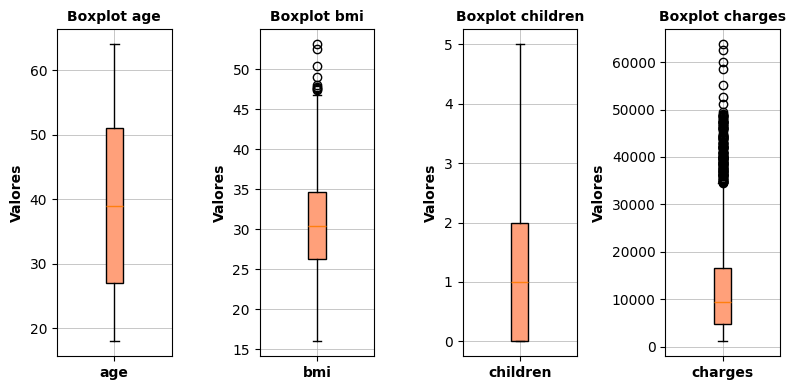

In [128]:
# # Crear la figura y los subplots.
fig, axs = plt.subplots(1,4, figsize=(8, 4))
# Se deja el array en una dimension para no usar indices con dos dimensiones
axs = axs.flatten()
# Columnas numéricas a graficar
numerical_cols = df.select_dtypes(include=['int64','float64'])
# Boxplot para las columnas numéricas
prop_caja = dict(facecolor='lightsalmon')
for i, col in enumerate(numerical_cols[:6]):
  axs[i].boxplot(df[col], patch_artist=True, boxprops=prop_caja)
  axs[i].set_title(f"Boxplot {col}", fontsize=10, fontweight='bold')
  axs[i].set_xticklabels([col], fontweight='bold')
  axs[i].set_ylabel("Valores", fontweight='bold')
  axs[i].grid(True, linewidth=0.5)

plt.tight_layout()
plt.show()

* El boxplot de edad muestra una media cerca de 40, la mayoria de los datos estan entre 20 y 60 años, su bigote superior sobre el valor 50 y bigote inferior bajo el valor 30. los valores estan dentro de los bigotes que son rangos esperados. No se observan valores atipicos.
* El boxplot de bmi muestra media cerca de 30, valores atipicos se encuentran sobre el bigote superior, a partir de 45 hacia arriba.
* El boxplot de children no tiene bigote inferior y su media esta cerca de 1, bigote superior muy alt, sin outliers por sobre el bigote.
* El boxplot de charges tiene bigote inferior corto y su media esta cerca de 10.000, muchos valores a partir de 40.000, con varios outliers cerca de 60.000.
* Para eliminar los outliers, se debe ser cuidadoso, puesto que son datos medicos y quitarlos, podria influir en que la muestra sea real.



In [129]:
df[(df["charges"]>=50000) & (df["charges"]<70000)]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


In [130]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

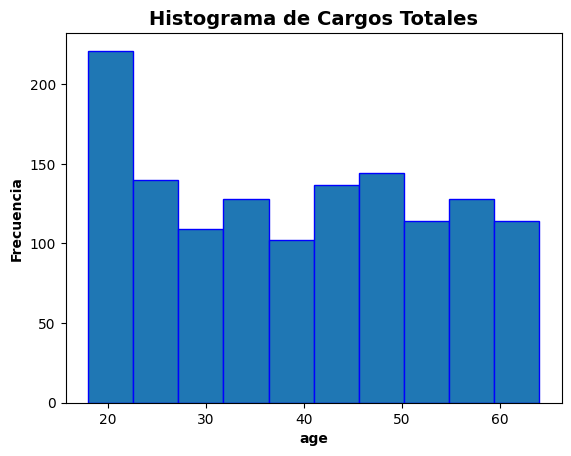

In [131]:
# grafico histograma que muestra la distribución de frecuencia de columna 'age'

plt.hist(df["age"], bins=10, edgecolor='blue')
plt.title('Histograma de Cargos Totales', fontsize=14, fontweight='bold')
plt.xlabel('age', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.show()



Gráfico con valores entre 20 y 60, con datos distribidos en forma normal y frecuencia alta alrededor de 20 años.

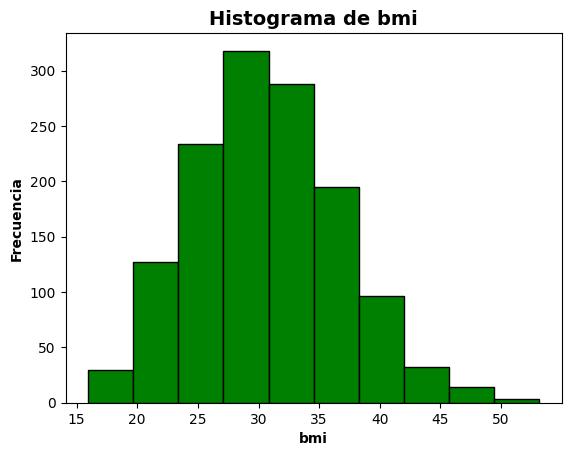

In [132]:
# grafico histograma que muestra la distribución de frecuencia de columna 'bmi'

plt.hist(df["bmi"], bins=10, color='green', edgecolor='black')
plt.title('Histograma de bmi', fontsize=14, fontweight='bold')
plt.xlabel('bmi', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.show()


Gráfico balanceado, con rango de datos entre 30 y 35, con frecuencia alta, entre el rango de 25 y 50.

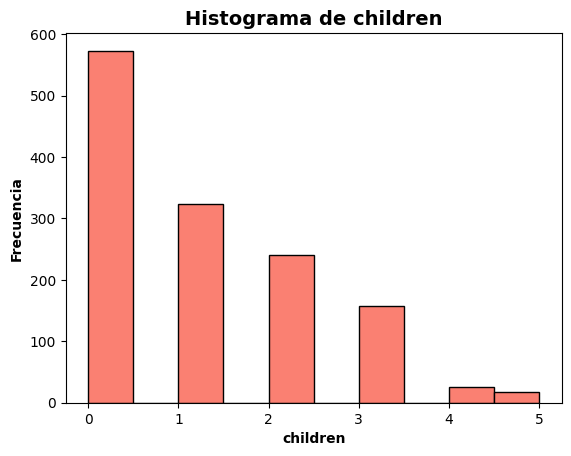

In [133]:
# grafico histograma que muestra la distribución de frecuencia de columna 'children'

plt.hist(df["children"], bins=10, color='salmon', edgecolor='black')
plt.title('Histograma de children', fontsize=14, fontweight='bold')
plt.xlabel('children', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.show()

* Gráfico sesgado hacia la izquierda con valores entre 0 y 5, la frecuencia más alta esta en el rango de cantidad de niños 0 y 1.

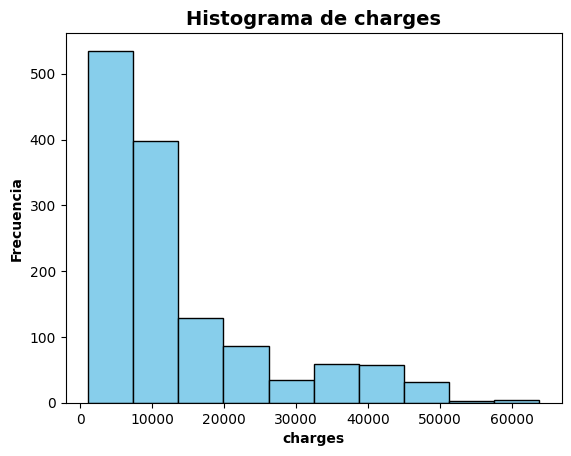

In [134]:
# grafico histograma que muestra la distribución de frecuencia de columna 'charges'

plt.hist(df["charges"], bins=10, color='skyblue', edgecolor='black')
plt.title('Histograma de charges', fontsize=14, fontweight='bold')
plt.xlabel('charges', fontweight='bold')
plt.ylabel('Frecuencia', fontweight='bold')
plt.show()

* Gráfico sesgado a la izquierda con valores entre 0 y 60000,
con frecuencias muy altas en valores entre 0 y 10000.

In [135]:
# Se reviza los datos con la correlaciones de Pearson
correlation_matrix = numerical_cols.corr(method='pearson')
print(correlation_matrix)

               age       bmi  children   charges
age       1.000000  0.109344  0.041536  0.298308
bmi       0.109344  1.000000  0.012755  0.198401
children  0.041536  0.012755  1.000000  0.067389
charges   0.298308  0.198401  0.067389  1.000000


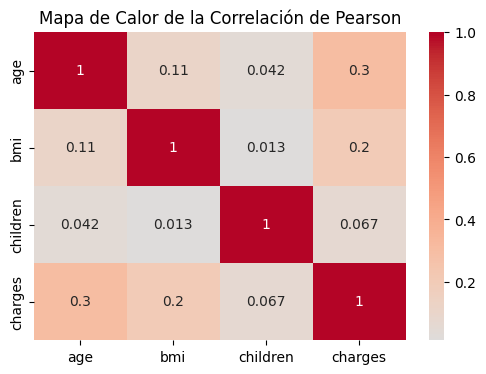

In [136]:
# Se Crea el  mapas de calor
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Mapa de Calor de la Correlación de Pearson")
plt.show()

* Correlación entre age y charges de 0.3 moderada.
* Correlación entre bmi y charges de 0.2 debil.
* las otras correlaciones son insignificantes.

Regresión Logística, K-Nearest Neighbors (KNN), y Árbol de Decisión.

#### Para implementar modelos de Casificación se debe transformar la variable objetivo 'charges' en categoria/clases, porque la columna tiene valores continuos.
#### Se crea columna charges_categoria

In [137]:
# Se calcula los percentiles 33.3% y 66.6%
p33 = df["charges"].quantile(1/3)
p66 = df["charges"].quantile(2/3)


In [138]:
# Se crea columna categorica
df["charges_categoria"] = 'alto'
df.loc[df["charges"] <= p66, 'charges_categoria'] = 'medio'
df.loc[df["charges"] <=p33, 'charges_categoria'] = 'bajo'

In [139]:
# Separación de las columnas
num_cols = ['age', 'bmi', 'children']
cat_cols = ['smoker', 'region']

In [140]:
# Division de la data
X = df.drop(columns=["charges","charges_categoria"])
y = df["charges_categoria"]

In [141]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Modelo LogisticRegression

In [142]:
# Preprocesador para LogisticRegression
preprocessor_lr = ColumnTransformer(transformers=[
    ("num_lr", StandardScaler(), num_cols),
    ("cat_lr", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_lr = Pipeline([
    ("preprocessing_lr", preprocessor_lr),
    ("model_lr", LogisticRegression())
])

In [143]:
# Entrenamiento.
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_lr',
                 ColumnTransformer(transformers=[('num_lr', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_lr',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_lr', LogisticRegression())])

In [144]:
# Prediccion.
y_pred_lr = pipeline_lr.predict(X_test)

In [145]:
 #Evaluación LogisticRegression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"\nModelo LogisticRegression")
print(f"\nAccuracy del modelo: {accuracy_lr:.2f}")
print(f"Precisión del modelo: {precision_lr:.2f}")
print(f"Recall del modelo: {recall_lr:.2f}")
print(f"F1_Score del modelo: {f1_lr:.2f}")



Modelo LogisticRegression

Accuracy del modelo: 0.86
Precisión del modelo: 0.89
Recall del modelo: 0.86
F1_Score del modelo: 0.86


#### Optimización parametros con Gridsearch para LogisticRegression

In [146]:
# Preprocesador para LogicticRegression
preprocessor_lr1 = ColumnTransformer(transformers=[
    ("num_lr1", StandardScaler(), num_cols),
    ("cat_lr1", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_lr1 = Pipeline([
    ("preprocessing_lr1", preprocessor_lr1),
    ("model_lr1", LogisticRegression(dual=False))
])

In [147]:
# Optimizacion de hiperparametros.
params_lr1 = {
    "model_lr1__max_iter": [100, 200, 300, 1000],
    "model_lr1__random_state": [42]
}

lr1_grid = GridSearchCV(pipeline_lr1, params_lr1, cv=5, scoring="accuracy")
lr1_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_lr1',
                                        ColumnTransformer(transformers=[('num_lr1',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat_lr1',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['smoker',
                                                                          'region'])])),
                                       ('model_lr1', LogisticRegression())]),
             param_grid={'model_lr1__max_iter': [100, 200, 300, 1000],
                         'model_lr1__random_state': [42]},
             scoring='accuracy')

In [148]:
# Evaluación.
lr1_best = lr1_grid.best_estimator_
y_pred_lr1 = lr1_best.predict(X_test)
accuracy_lr1 = accuracy_score(y_test, y_pred_lr1)
print("\nGridsearch con LogisticRegression")
print("\nMejores parámetros:", lr1_grid.best_params_)
print(f"Accuracy del modelo: {accuracy_lr1:.2f}")


Gridsearch con LogisticRegression

Mejores parámetros: {'model_lr1__max_iter': 100, 'model_lr1__random_state': 42}
Accuracy del modelo: 0.86


#### LogisticRegression optimizado con Gridsearch

In [149]:
# Preprocesador para LogisticRegression
preprocessor_lr2 = ColumnTransformer(transformers=[
    ("num_lr2", StandardScaler(), num_cols),
    ("cat_lr2", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_lr2 = Pipeline([
    ("preprocessing_lr2", preprocessor_lr2),
    ("model_lr2", LogisticRegression(max_iter=100, random_state=42))
])

In [150]:
# Entrenamiento.
pipeline_lr2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_lr2',
                 ColumnTransformer(transformers=[('num_lr2', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_lr2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_lr2', LogisticRegression(random_state=42))])

In [151]:
# Prediccion.
y_pred_lr2 = pipeline_lr2.predict(X_test)

In [152]:
#Evaluación LogisticRegression optimizado
accuracy_lr2 = accuracy_score(y_test, y_pred_lr2)
precision_lr2 = precision_score(y_test, y_pred_lr2, average='weighted')
recall_lr2 = recall_score(y_test, y_pred_lr2, average='weighted')
f1_lr2 = f1_score(y_test, y_pred_lr2, average='weighted')
cm_lr2 = confusion_matrix(y_test, y_pred_lr2)
print(f"\nLogisticRegression optimizado con Gridsearch")
print(f"\nAccuracy del modelo: {accuracy_lr2:.2f}")
print(f"Precisión del modelo: {precision_lr2:.2f}")
print(f"Recall del modelo: {recall_lr2:.2f}")
print(f"F1_Score del modelo: {f1_lr2:.2f}")
print(cm_lr2)


LogisticRegression optimizado con Gridsearch

Accuracy del modelo: 0.86
Precisión del modelo: 0.89
Recall del modelo: 0.86
F1_Score del modelo: 0.86
[[53  7 24]
 [ 0 83  6]
 [ 0  0 95]]


#### Optimización parametros RandomizedSearchCV para LogisticRegression.

In [153]:
param_dist = {
      "model_lr__max_iter": [100, 200, 500]  # Máximo de iteraciones
}

# Número de combinaciones aleatorias a probar
n_iter_search = 20

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline_lr, param_distributions=param_dist, n_iter=n_iter_search,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada de 5 folds
    scoring="accuracy",  # Métrica a optimizar (puede ser "f1", "roc_auc", etc.)
    random_state=42,

)
random_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=20. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing_lr',
                                              ColumnTransformer(transformers=[('num_lr',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('cat_lr',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['smoker',
                                                                                'region'])])),
                                             ('model_lr',
                                              LogisticRegression())]),
                   n_iter=20,
                   param_distributions={'model_lr__max_iter': [100, 200, 500]},
                   random_state=42, scoring='accuracy')

In [154]:
print("\nMejores hiperparámetros:", random_search.best_params_)
print("Mejor score (accuracy):", random_search.best_score_)



Mejores hiperparámetros: {'model_lr__max_iter': 100}
Mejor score (accuracy): 0.837229608178667


#### LogisticRegression Optimizado con RandomizedSearchCV

In [155]:
#### Modelo Optimizado max_iter=10, random_state=42 logicticRegression
preprocessor_lr2 = ColumnTransformer(transformers=[
    ("num_lr2", StandardScaler(), num_cols),
    ("cat_lr2", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_lr2 = Pipeline([
    ("preprocessing_lr2", preprocessor_lr2),
    ("model_lr2", LogisticRegression(max_iter=100))
])

In [156]:
# Entrenamiento.
pipeline_lr2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_lr2',
                 ColumnTransformer(transformers=[('num_lr2', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_lr2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_lr2', LogisticRegression())])

In [157]:
# Prediccion.
y_pred_lr2 = pipeline_lr2.predict(X_test)

In [158]:
#Evaluación LogisticRegression
accuracy_lr2 = accuracy_score(y_test, y_pred_lr2)
precision_lr2 = precision_score(y_test, y_pred_lr2, average='weighted')
recall_lr2 = recall_score(y_test, y_pred_lr2, average='weighted')
f1_lr2 = f1_score(y_test, y_pred_lr2, average='weighted')
cm_lr2 = confusion_matrix(y_test, y_pred_lr2)
print(f"\nLogisticRegression Optimizado con RandomizedSearchCV")
print(f"\nAccuracy del modelo: {accuracy_lr2:.2f}")
print(f"recisión del modelo: {precision_lr2:.2f}")
print(f"Recall del modelo: {recall_lr2:.2f}")
print(f"F1_Score del modelo: {f1_lr2:.2f}")
print(f"Matriz de Confusíon del modelo:")
print(cm_lr2)


LogisticRegression Optimizado con RandomizedSearchCV

Accuracy del modelo: 0.86
recisión del modelo: 0.89
Recall del modelo: 0.86
F1_Score del modelo: 0.86
Matriz de Confusíon del modelo:
[[53  7 24]
 [ 0 83  6]
 [ 0  0 95]]


Modelo KNeighborsClassifier

In [159]:
#### Modelo KNeighborsClassifier
preprocessor_knn = ColumnTransformer(transformers=[
    ("num_knn", StandardScaler(), num_cols),
    ("cat_knn", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_knn = Pipeline([
    ("preprocessing_knn", preprocessor_knn),
    ("model_knn", KNeighborsClassifier())
])

In [160]:
# Entrenamiento.
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_knn',
                 ColumnTransformer(transformers=[('num_knn', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_knn',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_knn', KNeighborsClassifier())])

In [161]:
# Prediccion.
y_pred_knn = pipeline_knn.predict(X_test)

In [162]:
#Evaluación KNeighborsClassifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
print(f"\nModelo KNeighborsClassifier")
print(f"\nAccuracy del modelo: {accuracy_knn:.2f}")
print(f"Precisión del modelo: {precision_knn:.2f}")
print(f"Recall del modelo: {recall_knn:.2f}")
print(f"F1_Score del modelo: {f1_knn:.2f}")
print(f"Matriz de Confusíon del modelo:")



Modelo KNeighborsClassifier

Accuracy del modelo: 0.85
Precisión del modelo: 0.86
Recall del modelo: 0.85
F1_Score del modelo: 0.85
Matriz de Confusíon del modelo:


#### Optimización parametros con Gridsearch para KNeighborsClassifier

In [163]:
# Preprocesador para KNeighborsClassifier
preprocessor_knn1 = ColumnTransformer(transformers=[
    ("num_knn1", StandardScaler(), num_cols),
    ("cat_knn1", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_knn1 = Pipeline([
    ("preprocessing_knn1", preprocessor_knn1),
    ("modelknn1", KNeighborsClassifier())
])

In [164]:
# Optimizacion de hiperparametros.
params_knn1 = {
    "modelknn1__n_neighbors": [2, 3, 5, 10],
}
knn1_grid = GridSearchCV(pipeline_knn1, params_knn1, cv=5, scoring="accuracy")
knn1_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_knn1',
                                        ColumnTransformer(transformers=[('num_knn1',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat_knn1',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['smoker',
                                                                          'region'])])),
                                       ('modelknn1', KNeighborsClassifier())]),
             param_grid={'modelknn1__n_neighbors': [2, 3, 5, 10]},
             scoring='accuracy')

In [165]:
# Evaluación.
knn1_best = knn1_grid.best_estimator_
y_pred_knn1 = knn1_best.predict(X_test)
accuracy_knn1 = accuracy_score(y_test, y_pred_knn1)
print("\nGridsearch con KNeighborsClassifier")
print("\nMejores parámetros:", knn1_grid.best_params_)
print(f"Accuracy del modelo: {accuracy_knn1:.2f}")


Gridsearch con KNeighborsClassifier

Mejores parámetros: {'modelknn1__n_neighbors': 10}
Accuracy del modelo: 0.87


#### KNeighborsClassifier optimizado con Gridsearch

In [166]:
# Preprocesador para KNeighborsClassifier
preprocessor_knn2 = ColumnTransformer(transformers=[
    ("num_knn2", StandardScaler(), num_cols),
    ("cat_knn2", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_knn2 = Pipeline([
    ("preprocessing_knn2", preprocessor_lr2),
    ("model_knn2", KNeighborsClassifier(n_neighbors=10))
])

In [167]:
# Entrenamiento.
pipeline_knn2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_knn2',
                 ColumnTransformer(transformers=[('num_lr2', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_lr2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_knn2', KNeighborsClassifier(n_neighbors=10))])

In [168]:
# Prediccion.
y_pred_knn2 = pipeline_knn2.predict(X_test)

In [169]:
#Evaluación KNeighborsClassifier optimizado
accuracy_knn2 = accuracy_score(y_test, y_pred_knn2)
precision_knn2 = precision_score(y_test, y_pred_knn2, average='weighted')
recall_knn2 = recall_score(y_test, y_pred_knn2, average='weighted')
f1_knn2 = f1_score(y_test, y_pred_knn2, average='weighted')
cm_knn2 = confusion_matrix(y_test, y_pred_knn2)
print(f"\nKNeighborsClassifier Optimizado con Gridsearch")
print(f"\nAccuracy del modelo: {accuracy_knn2:.2f}")
print(f"Precisión del modelo: {precision_knn2:.2f}")
print(f"Recall del modelo: {recall_knn2:.2f}")
print(f"F1_Score del modelo: {f1_knn2:.2f}")
print(cm_knn2)


KNeighborsClassifier Optimizado con Gridsearch

Accuracy del modelo: 0.87
Precisión del modelo: 0.88
Recall del modelo: 0.87
F1_Score del modelo: 0.87
[[58  7 19]
 [ 0 85  4]
 [ 4  1 90]]


#### Optimización parametros con RandomizedSearchCV para KNeighborsClassifier

In [170]:
param_dist_knn = {
      "model_knn__n_neighbors": [100, 200, 500]  # Máximo de iteraciones
}

# Número de combinaciones aleatorias a probar
n_iter_search = 20

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline_knn, param_distributions=param_dist_knn, n_iter=n_iter_search,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada de 5 folds
    scoring="accuracy",  # Métrica a optimizar (puede ser "f1", "roc_auc", etc.)

)
random_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=20. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing_knn',
                                              ColumnTransformer(transformers=[('num_knn',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('cat_knn',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['smoker',
                                                                                'region'])])),
                                             ('model_knn',
                                              KNeighborsClassifier())]),
                   n_iter=20,
                   param_distributions={'model_knn__n_neighbors': [100, 200,
                                                                   500]},
                   scoring='accuracy')

In [171]:
print("\nMejores hiperparámetros:", random_search.best_params_)
print("Mejor score (accuracy):", random_search.best_score_)



Mejores hiperparámetros: {'model_knn__n_neighbors': 100}
Mejor score (accuracy): 0.8120135141064455


####  KNeighborsClassifier Optimizado con RandomizedSearchCV

In [172]:
# Preprocesador para KNeighborsClassifier con RandomizedSearchCV
preprocessor_knn3 = ColumnTransformer(transformers=[
    ("num_knn3", StandardScaler(), num_cols),
    ("cat_knn3", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_knn3 = Pipeline([
    ("preprocessing_knn3", preprocessor_knn3),
    ("model_knn3", KNeighborsClassifier(n_neighbors=10))
])

In [173]:
# Entrenamiento.
pipeline_knn3.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_knn3',
                 ColumnTransformer(transformers=[('num_knn3', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_knn3',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_knn3', KNeighborsClassifier(n_neighbors=10))])

In [174]:
# Prediccion.
y_pred_knn3 = pipeline_knn3.predict(X_test)

In [175]:
#Evaluación KNeighborsClassifier optimizado con RandomizedSearchCV
accuracy_knn3 = accuracy_score(y_test, y_pred_knn3)
precision_knn3 = precision_score(y_test, y_pred_knn3, average='weighted')
recall_knn3 = recall_score(y_test, y_pred_knn3, average='weighted')
f1_knn3 = f1_score(y_test, y_pred_knn3, average='weighted')
cm_knn3 = confusion_matrix(y_test, y_pred_knn3)
print(f"\nKNeighborsClassifier Optimizado con con RandomizedSearchCV")
print(f"\nAccuracy del modelo: {accuracy_knn3:.2f}")
print(f"Precisión del modelo: {precision_knn3:.2f}")
print(f"Recall del modelo: {recall_knn3:.2f}")
print(f"F1_Score del modelo: {f1_knn3:.2f}")
print(cm_knn3)


KNeighborsClassifier Optimizado con con RandomizedSearchCV

Accuracy del modelo: 0.87
Precisión del modelo: 0.88
Recall del modelo: 0.87
F1_Score del modelo: 0.87
[[58  7 19]
 [ 0 85  4]
 [ 4  1 90]]


Modelo de DecisionTreeClassifier

In [176]:
#### Modelo  DecisionTreeClassifier
preprocessor_tree = ColumnTransformer(transformers=[
    ("num_tree", 'passthrough', num_cols),
    ("cat_tree", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_tree = Pipeline([
    ("preprocessing_tree", preprocessor_tree),
    ("model_tree",  DecisionTreeClassifier())
])

In [177]:
# Entrenamiento.
pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_tree',
                 ColumnTransformer(transformers=[('num_tree', 'passthrough',
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_tree',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_tree', DecisionTreeClassifier())])

In [178]:
# Prediccion.
y_pred_tree = pipeline_tree.predict(X_test)

In [179]:
#Evaluación DecisionTreeClassifier
accuracy_tree = accuracy_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree, average='weighted')
recall_tree = recall_score(y_test, y_pred_tree, average='weighted')
f1_tree = f1_score(y_test, y_pred_tree, average='weighted')
print(f"\nModelo DecisionTreeClassifier")
print(f"\nAccuracy del modelo: {accuracy_tree:.2f}")
print(f"Precisión del modelo: {precision_tree:.2f}")
print(f"Recall del modelo: {recall_tree:.2f}")
print(f"F1_Score del modelo: {f1_tree:.2f}")
print(f"Matriz de Confusíon del modelo:")


Modelo DecisionTreeClassifier

Accuracy del modelo: 0.82
Precisión del modelo: 0.83
Recall del modelo: 0.82
F1_Score del modelo: 0.83
Matriz de Confusíon del modelo:


#### Optimización parametros con Gridsearch para DecisionTreeClassifier

In [180]:
# Preprocesador para DecisionTreeClassifier
preprocessor_tree1 = ColumnTransformer(transformers=[
    ("num_tree1",  'passthrough', num_cols),
    ("cat_tree1", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_tree1 = Pipeline([
    ("preprocessing_tree1", preprocessor_tree),
    ("modeltree1", DecisionTreeClassifier())
])

In [181]:
# Optimizacion de hiperparametros con Gridsearch.
params_tree1 = {
    "modeltree1__max_depth": [2, 3, 5, 10],
}
tree1_grid = GridSearchCV(pipeline_tree1, params_tree1, cv=5, scoring="accuracy")
tree1_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_tree1',
                                        ColumnTransformer(transformers=[('num_tree',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat_tree',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['smoker',
                                                                          'region'])])),
                                       ('modeltree1',
                                        DecisionTreeClassifier())]),
             param_grid={'modeltree1__max_depth': [2, 3, 5, 10]},
             scoring='accuracy')

In [182]:
# Evaluación.
tree1_best = tree1_grid.best_estimator_
y_pred_tree1 = tree1_best.predict(X_test)
accuracy_tree1 = accuracy_score(y_test, y_pred_tree1)
print("\nGridsearch con DecisionTreeClassifier")
print("\nMejores parámetros:", tree1_grid.best_params_)
print(f"Accuracy del modelo: {accuracy_tree1:.2f}")


Gridsearch con DecisionTreeClassifier

Mejores parámetros: {'modeltree1__max_depth': 5}
Accuracy del modelo: 0.90


DecisionTreeClassifier Optimizado con Gridsearch

In [183]:
#### Modelo  DecisionTreeClassifier Optimizado con Gridsearch
preprocessor_tree2 = ColumnTransformer(transformers=[
    ("num_tree2", 'passthrough', num_cols),
    ("cat_tree2", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_tree2 = Pipeline([
    ("preprocessing_tree2", preprocessor_tree),
    ("model_tree2",  DecisionTreeClassifier(max_depth=5))
])

In [184]:
# Entrenamiento.
pipeline_tree2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_tree2',
                 ColumnTransformer(transformers=[('num_tree', 'passthrough',
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_tree',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_tree2', DecisionTreeClassifier(max_depth=5))])

In [185]:
# Prediccion.
y_pred_tree2 = pipeline_tree2.predict(X_test)

In [186]:
#Evaluación DecisionTreeClassifier optimizado con Gridsearch
accuracy_tree2 = accuracy_score(y_test, y_pred_tree2)
precision_tree2 = precision_score(y_test, y_pred_tree2, average='weighted')
recall_tree2 = recall_score(y_test, y_pred_tree2, average='weighted')
f1_tree2 = f1_score(y_test, y_pred_knn3, average='weighted')
cm_tree2 = confusion_matrix(y_test, y_pred_tree2)
print(f"\nDecisionTreeClassifier Optimizado con Gridsearch")
print(f"\nAccuracy del modelo: {accuracy_tree2:.2f}")
print(f"Precisión del modelo: {precision_tree2:.2f}")
print(f"Recall del modelo: {recall_tree2:.2f}")
print(f"F1_Score del modelo: {f1_tree2:.2f}")
print(cm_tree2)


DecisionTreeClassifier Optimizado con Gridsearch

Accuracy del modelo: 0.90
Precisión del modelo: 0.90
Recall del modelo: 0.90
F1_Score del modelo: 0.87
[[68  7  9]
 [ 0 86  3]
 [ 0  9 86]]


#### Optimización parametros con RandomizedSearchCV para DecisionTreeClassifier

In [187]:
param_dist_tree = {
      "model_tree__max_depth": randint(1,20)
}

# Número de combinaciones aleatorias a probar
n_iter_search = 20

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline_tree, param_distributions=param_dist_tree, n_iter=n_iter_search,  # Número de combinaciones a probar
    cv=5,  # Validación cruzada de 5 folds
    scoring="accuracy",

)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing_tree',
                                              ColumnTransformer(transformers=[('num_tree',
                                                                               'passthrough',
                                                                               ['age',
                                                                                'bmi',
                                                                                'children']),
                                                                              ('cat_tree',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['smoker',
                                                                                'region'])])),
                                             ('model_tree',
                                              DecisionTreeClassifier())]),
                   n_iter=20,
                   param_distributions={'model_tree__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x781a8c152b90>},
                   scoring='accuracy')

In [188]:
print("\nMejores hiperparámetros:", random_search.best_params_)
print("Mejor score (accuracy):", random_search.best_score_)



Mejores hiperparámetros: {'model_tree__max_depth': 6}
Mejor score (accuracy): 0.8821113597472687


DecisionTreeClassifier Optimizado con RandomizedSearchCV

In [189]:
#### Modelo  DecisionTreeClassifier optimizado
preprocessor_tree3 = ColumnTransformer(transformers=[
    ("num_tree3", 'passthrough', num_cols),
    ("cat_tree3", OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Modelo.
pipeline_tree3 = Pipeline([
    ("preprocessing_tree3", preprocessor_tree3),
    ("model_tree3",  DecisionTreeClassifier(max_depth=5))
])

In [190]:
# Entrenamiento.
pipeline_tree3.fit(X_train, y_train)

Pipeline(steps=[('preprocessing_tree3',
                 ColumnTransformer(transformers=[('num_tree3', 'passthrough',
                                                  ['age', 'bmi', 'children']),
                                                 ('cat_tree3',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['smoker', 'region'])])),
                ('model_tree3', DecisionTreeClassifier(max_depth=5))])

In [191]:
# Prediccion.
y_pred_tree3 = pipeline_tree3.predict(X_test)

In [227]:
#Evaluación DecisionTreeClassifier optimizado con Gridsearch
accuracy_tree3 = accuracy_score(y_test, y_pred_tree3)
precision_tree3 = precision_score(y_test, y_pred_tree3, average='weighted')
recall_tree3 = recall_score(y_test, y_pred_tree3, average='weighted')
f1_tree3 = f1_score(y_test, y_pred_tree3, average='weighted')
cm_tree3 = confusion_matrix(y_test, y_pred_tree3)
print(f"\nDecisionTreeClassifier Optimizado con RandomizedSearchCV")
print(f"\nAccuracy del modelo: {accuracy_tree3:.2f}")
print(f"Precisión del modelo: {precision_tree3:.2f}")
print(f"Recall del modelo: {recall_tree3:.2f}")
print(f"F1_Score del modelo: {f1_tree3:.2f}")
print(cm_tree3)


DecisionTreeClassifier Optimizado con RandomizedSearchCV

Accuracy del modelo: 0.90
Precisión del modelo: 0.90
Recall del modelo: 0.90
F1_Score del modelo: 0.90
[[68  7  9]
 [ 0 86  3]
 [ 0  9 86]]


#### Validación cruzadas de los modelos Sin optimizar

In [210]:

print(f"\nLogisticRegression      Accuracy:{accuracy_lr:.2f}   Precisión:{precision_lr:.2f}  Recall:{recall_lr:.2f}  F1_Score:{f1_lr:.2f}")
print(f"KNeighborsClassifier    Accuracy:{accuracy_knn:.2f}   Precisión:{precision_knn:.2f}  Recall:{recall_knn:.2f}  F1_Score:{f1_knn:.2f}")
print(f"DecisionTreeClassifier  Accuracy:{accuracy_tree:.2f}   Precisión:{precision_tree:.2f}  Recall:{recall_tree:.2f}  F1_Score:{f1_tree:.2f}")



LogisticRegression      Accuracy:0.86   Precisión:0.89  Recall:0.86  F1_Score:0.86
KNeighborsClassifier    Accuracy:0.85   Precisión:0.86  Recall:0.85  F1_Score:0.85
DecisionTreeClassifier  Accuracy:0.82   Precisión:0.83  Recall:0.82  F1_Score:0.83


#### Validación cruzadas de los modelos con optimización

In [232]:
print(f"\nLogisticRegression       con Gridsearch          Accuracy:{accuracy_lr2:.2f} Precisión:{precision_lr2:.2f} Recall:{recall_lr2:.2f} F1_Score:{f1_lr2:.2f}")
print(f"LogisticRegression       con RandomizedSearchCV  Accuracy:{accuracy_lr2:.2f} Precisión:{precision_lr2:.2f} Recall:{recall_lr2:.2f} F1_Score:{f1_lr2:.2f}")
print(f"KNeighborsClassifier     con Gridsearch          Accuracy:{accuracy_knn2:.2f} Precisión:{precision_knn2:.2f} Recall:{recall_knn2:.2f} F1_Score:{f1_knn2:.2f}" )
print(f"KNeighborsClassifier     con RandomizedSearchCV  Accuracy:{accuracy_knn3:.2f} Precisión:{precision_knn3:.2f} Recall:{recall_knn3:.2f} F1_Score:{f1_knn3:.2f}")
print(f"DecisionTreeClassifier   con Gridsearch          Accuracy:{accuracy_tree2:.2f} Precisión:{precision_tree2:.2f} Recall:{recall_tree2:.2f} F1_Score:{f1_tree2:.2f}")
print(f"DecisionTreeClassifier   con RandomizedSearchCV  Accuracy:{accuracy_tree3:.2f} Precisión:{precision_tree3:.2f} Recall:{recall_tree3:.2f} F1_Score:{f1_tree3:.2f}")



LogisticRegression       con Gridsearch          Accuracy:0.86 Precisión:0.89 Recall:0.86 F1_Score:0.86
LogisticRegression       con RandomizedSearchCV  Accuracy:0.86 Precisión:0.89 Recall:0.86 F1_Score:0.86
KNeighborsClassifier     con Gridsearch          Accuracy:0.87 Precisión:0.88 Recall:0.87 F1_Score:0.87
KNeighborsClassifier     con RandomizedSearchCV  Accuracy:0.87 Precisión:0.88 Recall:0.87 F1_Score:0.87
DecisionTreeClassifier   con Gridsearch          Accuracy:0.90 Precisión:0.90 Recall:0.90 F1_Score:0.87
DecisionTreeClassifier   con RandomizedSearchCV  Accuracy:0.90 Precisión:0.90 Recall:0.90 F1_Score:0.90


#### De los modelos evaluados, los que tiene mejor rendimiento son los DecisionTreeClassifier, tanto con Gridsearch, como con RandomizedSearchCV, ya que ambos alcanzan las siguientes metrícas:
Acurracy :0.90
Precision:0.90
Recall:0.90
F1-Score:0.90

Por lo tanto DecisionTreeClassfier el mejor opcion , segun los resultados mostrados.



#### Matriz de confusión

In [234]:
print(f"\nLogisticRegression Optimizado con RandomizedSearchCV")
print(cm_lr2)
print(f"\nKNeighborsClassifier Optimizado con RandomizedSearchCV")
print(cm_knn3)
print(f"\nDecisionTreeClassifier Optimizado con RandomizedSearchCV")
print(cm_tree3)


LogisticRegression Optimizado con RandomizedSearchCV
[[53  7 24]
 [ 0 83  6]
 [ 0  0 95]]

KNeighborsClassifier Optimizado con RandomizedSearchCV
[[58  7 19]
 [ 0 85  4]
 [ 4  1 90]]

DecisionTreeClassifier Optimizado con RandomizedSearchCV
[[68  7  9]
 [ 0 86  3]
 [ 0  9 86]]


#### LogisticRegression:
 * clase 1: 53 correctos, 7 como clase 2 y 24 como clase 3
 * clase 2: 83 correctos, 6 como clase 3.
 * clase 3: 95 correctos, 0 en clase 1 y 2

#### KNeighborsClassifier
 * clase 1: 158 correctos, 7 como clase 2, 19 como clase 3
 * clase 2: 85 correctos, 4 como clase 3.
 * clase 3: 90 correctos, 4 como clase 1, 1 como clase 2.
 * Mejor balance general que LogisticRegression, pero clase 3 ahora tiene mas errores, clase 1 mejora significativamente.

 ### DecisionTreeClassifier
 * clase 1: 68 correctos, 7 como clase 2 y 9 como clase 3.
 * clase 2: 86 correctos, 3 como clase 3.
 * clase 3: 86 correctos, 9 como clase 2.

 ####  DecisionTreeClassifier muestra el mejor balance entre las tres clases, LogisticRegression tiene problemas con clase 1, pero excelente con clase 3. KNeighborsClassifier  es intermedio.

AUC: 0.949


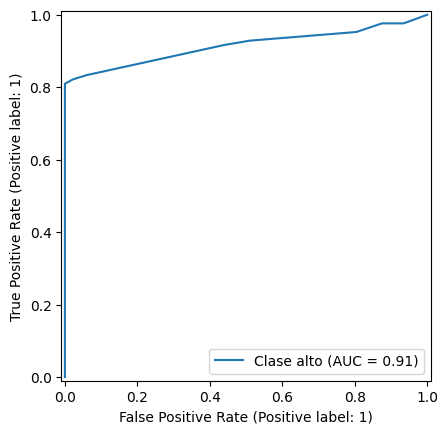

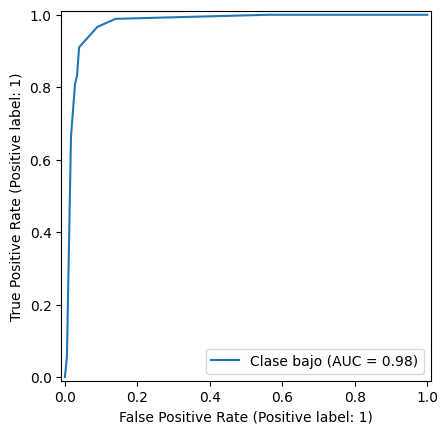

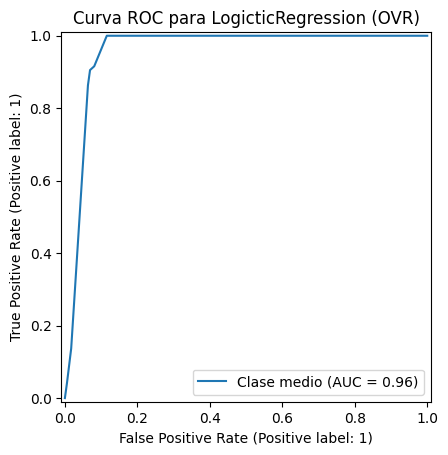

In [235]:
# Curva de ROC

# Obtener probabilidades para todas las clases
y_proba = pipeline_tree3.predict_proba(X_test)
# Calcular AUC para multi-class usando 'ovr' (uno contra el resto)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"AUC: {auc:.3f}")

from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
y_test_bin = lb.transform(y_test)

for i in range(y_proba.shape[1]):
     RocCurveDisplay.from_predictions(y_test_bin[:, i], y_proba[:, i], name=f'Clase {lb.classes_[i]}')

plt.title("Curva ROC para LogicticRegression (OVR)")
plt.show()

#### El modelo es altamente efectivo para la tarea de clasificación, con un margen minimo de error.